## Vlasov equations

We want to solve Vlosov equations on 1  (in $S^1$).

The equations are: 

\begin{align}
\partial_t f + p \partial_x f &= \frac{q}{m}E \partial_p f \\
\partial_t E = -4\pi J \\
\partial_x E = 4\pi \rho \\
\end{align}

Where $f = f(t,x,p)$ is a distribution function in phase espace. 
Note that the invarian volume element is, 

$$
dP = dp_x/p_0
$$ 

We define, the particle number with respect to an observer with four-velocity $u^a$,

$$
N = \int f(x,p)(-u \cdot p)\; dP
$$ 

Thus, for the observer at rest in the coordinate system $(t,x)$ we get

$$
N = \int f(x,p) p_0 \; dP = \int f(x,p) \; dp_x
$$ 

Otherwise one has the four-vector particle density,

$$
N^a = \int f(x,p) p^a \; dP = \int f(x,p) \frac{p^a}{p_0} \; dp_x
$$

Thus, 

$$
N^x = \int f(x,p) \frac{p_x}{p_0} \; dp_x
$$

Likewise we have the energy-momentum tensor,

$$
T^{ab} = \int p^a p^b f(x,p) dP 
$$

So, 

$$
T^{00} = \int p^0 f(x,p) dp_x = m \int \sqrt{1 + p^2/m^2} dp
$$




\begin{align}
\rho(t,x) &:= q\int f(t,x,p) \; dp - n_0 \\
n_0 &:= q \int \int f(t,x,p) \; dp \; dx / V\\
J(t,x) &:= q \int v f(t,x,p) \; dp, \\
v &:= \frac{\frac{p}{m}}{\sqrt{1 + \frac{p^2}{m^2}}} \\ 
\end{align}

And $E = E(t,x)$ is the electric field.


The equilibrium distribution function is: 

$$
f(\gamma) = \frac{\gamma^2 \beta}{\theta K_2(\frac{1}{\theta})}\; e^{-\frac{\gamma}{\theta}} \;\;\;\; \gamma = \frac{1}{\sqrt{1 - \beta^2}}
$$ 

or

$$
f(p) = \frac{1}{4\pi m^3 c^3 \theta K_2(\frac{1}{\theta})} \; e^{-\frac{\gamma(p)}{\theta}} \;\;\;\;\; \gamma(p) = \sqrt{1 + (\frac{p}{m})^2}
$$

and $K_2$ is the Bessel function of second kind.

In [97]:
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")

nthreads = 1


In [98]:
include("aux_functions_vlasov.jl")

LoadError: LoadError: ArgumentError: Invalid use of @view macro: argument must be a reference expression A[...].
in expression starting at /Users/reula/Julia/Vlasov/aux_functions_vlasov.jl:268
in expression starting at /Users/reula/Julia/Vlasov/aux_functions_vlasov.jl:268

In [99]:
Nx = 200 # usar par para Fourier transform
Np = 201 # we take even since we need positive and negative values
Lx = 1
Lp = 0.5 # para cada lado
dx = Lx/Nx # periodic boundary conditions
dp = 2*Lp/(Np-1) # Dichlet... or whatever but not periodic

const m = 1
const e =-1
#const q = 1
α = 0.01
n = 4
k = 2*π*n/Lx
θ = 0.01
const κ = 2π/Lx


p = [get_p(j,dp,Np)/m for j ∈ 1:Np]
v = [p[j]/sqrt(1+p[j]^2) for j ∈ 1:Np];

In [100]:
#E = zeros(Nx)
#ϕ = zeros(Nx)
ρ = zeros(Nx) #charge density
S = zeros(Nx) #carge current
E_K = zeros(Nx) # kinetic energy
#E_E = zeros(Nx) # Electromagnetic energy
P = zeros(Nx) # Momentum
du = zeros(Nx * (Np+1)); # contains f and E


## Initial data

In [101]:
u = zeros(Nx * (Np+1))

pars_f = (θ, m, α, k)
pars = (Nx, dx, Lx, Np, dp, Lp, κ, e)
u = generate_initial_data!(landau_rel_dist, u, pars_f, pars);

#F = reshape(u[1:Nx*Np],(Nx,Np));
#plot_matrix(F)
#save("initial_dist_landau_big.png")

n0 = -7.448210028622257e-46
n0 = -1.0000000000000009


40400-element Vector{Float64}:
 3.0023436870429644e-5
 3.0021092872733713e-5
 3.0014097845889808e-5
 3.0002562105649904e-5
 2.998666757752868e-5
 2.9966664927729553e-5
 2.9942869609988862e-5
 2.9915656890681993e-5
 2.9885455930648524e-5
 2.9852743017069348e-5
 ⋮
 0.0045122376134778385
 0.004210537486889507
 0.003842434668879735
 0.0034137343607825435
 0.0029311974225498198
 0.0024024337499510178
 0.0018357822619710536
 0.0012401793910766276
 0.0006250181503376879

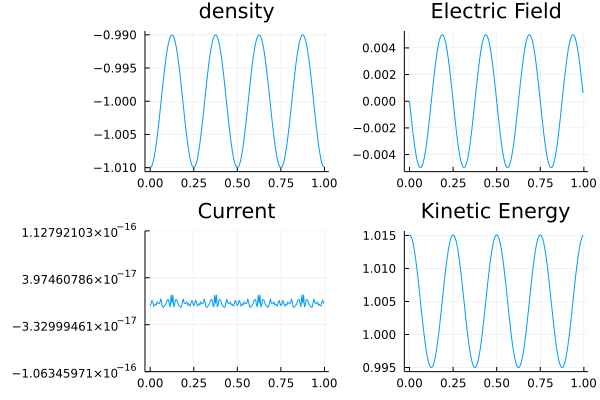

In [102]:
E_i = deepcopy(u[Nx*Np+1:end])
get_current!(u, S, (Nx, dx, Np, dp, v, m, e));
get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
plot(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))

x = [(i-1)*dx for i in 1:Nx]

plot(layout=(2,2))
plot!(subplot=1,x,ρ, title = "density", legend = :false)
plot!(subplot=2,x,E_i, title = "Electric Field", legend = :false)
plot!(subplot=3,x,S, title = "Current", legend = :false)
plot!(subplot=4,x,E_K, title = "Kinetic Energy", legend = :false)

## Time evolution

In [103]:
t = 0.0
t_i = 0.0
t_f = 1.40
M = 41
M_g = 40 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)


0.034999999999999996

In [104]:
dvx = zeros(Nx)
dvp = zeros(Np)
k1 = zeros(Nx*(Np+1))
k2 = zeros(Nx*(Np+1))
k3 = zeros(Nx*(Np+1))
k4 = zeros(Nx*(Np+1))
p_F = (dx, dp, Nx, Np, v, S, dvx, dvp)
par_RK = (k1, k2, k3, k4)

# total quantities 
Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
EField_T = zeros(M_g)
p_T = zeros(M_g)
n_T = zeros(M_g)
S_T = zeros(M_g)
E_E = 0.0
#T = zeros(M_g)

j = 1

Energy_K[j]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx
Energy_E[j]  = get_E_energy(u,(Nx, dx))
EField_T[j] = sum(u[Nx*Np+1:end])*dx
p_T[j] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))*dx

get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
get_current!(u, S, (Nx, dx, Np, dp, v, m, e))
n_T[j] = get_total_density!(ρ,(Nx, dx))
S_T[j] = sum(S)/n_T[j]/Nx
#T[1] = var(u[N+1:2N])

-1.4074537679593858e-19

In [105]:
#RK4_Step!(F!,u,t,dt,p_F,par_RK)

# hasta aquí llegué

In [106]:
#include("aux_functions_vlasov.jl")

for k in 2:M
    RK4_Step!(F!,u,t,dt,p_F,par_RK)
    global t = t + dt
    if (k-1) % (M÷(M_g-1)) == 0
        local j = (k-1)÷(M÷(M_g-1))+1
        Energy_K[j]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx
        Energy_E[j]  = get_E_energy(u,(Nx, dx))
        EField_T[j] = sum(u[Nx*Np+1:end])*dx
        p_T[j] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))*dx
        get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
        get_current!(u, S, (Nx, dx, Np, dp, v, m, e))
        n_T[j] = get_total_density!(ρ,(Nx, dx))
        S_T[j] = sum(S)/n_T[j]/Nx
        println("j = $j , t = $t, k = $k, nthreads = $(nthreads())")
    end
  end

j = 2 , t = 0.034999999999999996, k = 2, nthreads = 1
j = 3 , t = 0.06999999999999999, k = 3, nthreads = 1
j = 4 , t = 0.10499999999999998, k = 4, nthreads = 1
j = 5 , t = 0.13999999999999999, k = 5, nthreads = 1
j = 6 , t = 0.175, k = 6, nthreads = 1
j = 7 , t = 0.21, k = 7, nthreads = 1
j = 8 , t = 0.245, k = 8, nthreads = 1
j = 9 , t = 0.27999999999999997, k = 9, nthreads = 1
j = 10 , t = 0.31499999999999995, k = 10, nthreads = 1
j = 11 , t = 0.3499999999999999, k = 11, nthreads = 1
j = 12 , t = 0.3849999999999999, k = 12, nthreads = 1
j = 13 , t = 0.4199999999999999, k = 13, nthreads = 1
j = 14 , t = 0.45499999999999985, k = 14, nthreads = 1
j = 15 , t = 0.4899999999999998, k = 15, nthreads = 1
j = 16 , t = 0.5249999999999998, k = 16, nthreads = 1
j = 17 , t = 0.5599999999999998, k = 17, nthreads = 1
j = 18 , t = 0.5949999999999999, k = 18, nthreads = 1
j = 19 , t = 0.6299999999999999, k = 19, nthreads = 1
j = 20 , t = 0.6649999999999999, k = 20, nthreads = 1
j = 21 , t = 0.7, k = 

In [107]:
#F = reshape(u[1:Nx*Np],(Nx,Np));
#plot_matrix(F)




n0 = -1.0000000000000009


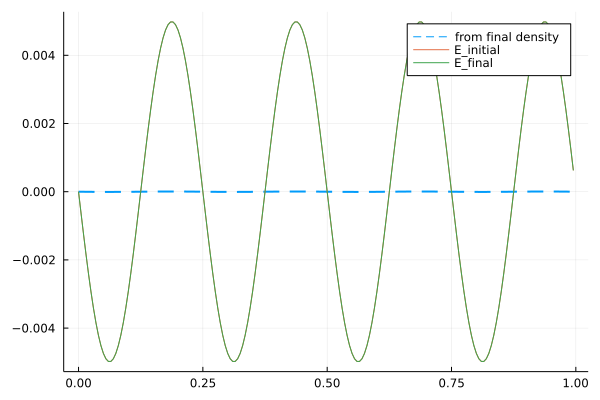

In [108]:
ρ_f = zeros(Nx)
E_f = zeros(Nx)
ϕ_f = zeros(Nx)

get_density!(u, ρ_f, (Nx, dx, Np, dp, m, e))
n0 = get_total_density!(ρ_f, (Nx, dx))
println("n0 = $(n0)")
get_ϕ!(ϕ_f, ρ_f .- e*n0, κ)
get_E_from_ϕ!(ϕ_f,E_f,dx)


plot(x,E_f,label="from final density", ls=:dash, lw=2)
plot!(x,E_i,label="E_initial")
plot!(x,u[Nx*Np+1:end], label="E_final")
#save("Efield_como_debiera.png")

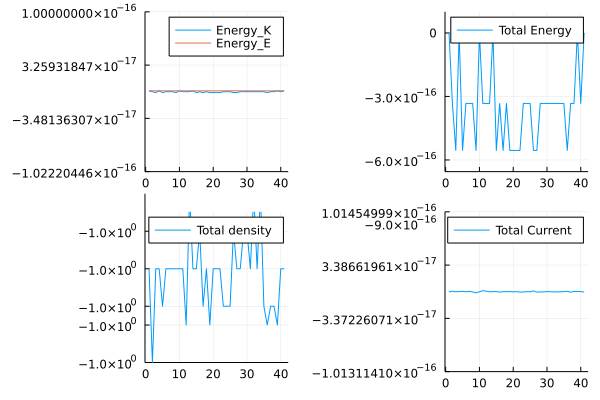

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/reula/.julia/packages/PlotUtils/rTTui/src/ticks.jl:333


In [109]:
factor = 200
plot(layout=(2,2))
plot!(subplot=1, (Energy_K .- Energy_K[1])*dx, label="Energy_K")
plot!(subplot=1, (Energy_E .- Energy_E[1]), label="Energy_E")
plot!(subplot=2, (Energy_K*dx + Energy_E) ./ (Energy_K[1]*dx + Energy_E[1]) .- 1, label="Total Energy")
plot!(subplot=3, n_T, label="Total density")
plot!(subplot=4, S_T, label="Total Current")

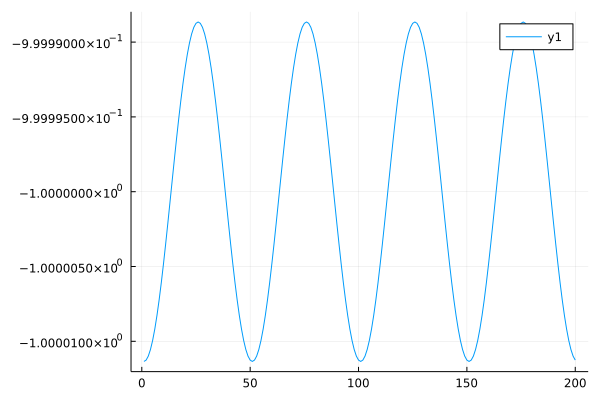

In [110]:
plot(ρ_f)

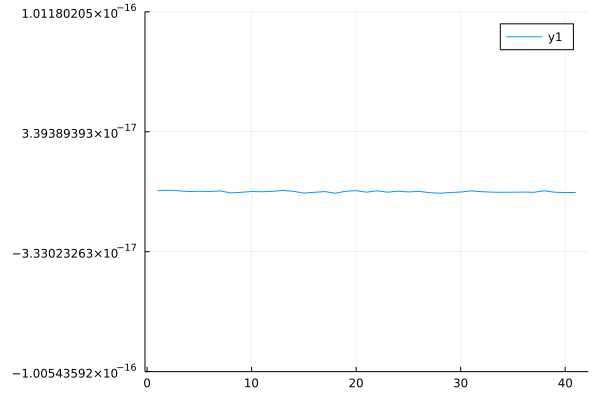

In [111]:
plot(p_T)